# Overview
- nb004の結果が一番良かった、欠損値平均補完/ランダムフォレストでパイプライン*pl_1*作成。
- 層化k分割交差検証を実施。また、訓練データ数を横軸にとったLearning Curve、ランダムフォレストの決定木数を横軸に取ったValidation Curveを作成。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_data_raw = pd.read_csv('../data/train.csv')
train_data_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Passengerid, Name, Ticket, Cabin列を除いた特徴量を取得
train_data = train_data_raw.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# Sex, Embarked列をone-hot encordし、それぞれ1列を削除する
train_data = pd.get_dummies(train_data, columns=['Sex', 'Embarked'], drop_first=True)
train_data_columns = train_data.columns.values

# 特徴量をX,ラベルをyとして分離しNumpy配列にする
X = train_data.drop(['Survived'], axis=1).values
y = train_data['Survived'].values
X

array([[ 3., 22.,  1., ...,  1.,  0.,  1.],
       [ 1., 38.,  1., ...,  0.,  0.,  0.],
       [ 3., 26.,  0., ...,  0.,  0.,  1.],
       ...,
       [ 3., nan,  1., ...,  0.,  0.,  1.],
       [ 1., 26.,  0., ...,  1.,  0.,  0.],
       [ 3., 32.,  0., ...,  1.,  1.,  0.]])

In [4]:
# 訓練用、テスト用にデータ分割する   !!!テストデータ情報の混入防止!!!
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)   # 訓練:テスト = 80:20

print('Label counts in y: [0 1] =', np.bincount(y))
print('Label counts in y_train: [0 1] =', np.bincount(y_train))
print('Label counts in y_test: [0 1] =', np.bincount(y_test))

Label counts in y: [0 1] = [549 342]
Label counts in y_train: [0 1] = [439 273]
Label counts in y_test: [0 1] = [110  69]


In [23]:
# Pipeline: pl_1
# 欠損値平均補完 / ランダムフォレスト
# ===================================

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pl_1 = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'),
                     StandardScaler(),
                     RandomForestClassifier(criterion='gini', n_estimators=100, random_state=21, n_jobs=2, max_depth=6))
pl_1.fit(X_train, y_train)
print('Accuracy: %.3f' % pl_1.score(X_test, y_test))

Accuracy: 0.810


In [24]:
# Stratified k-fold Cross Validation
# "StratifiedKFold"を使って手動
# ===================================

from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
scores = []

for k, (train, test) in enumerate(kfold):
    pl_1.fit(X_train[train], y_train[train])
    score = pl_1.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %d, Class dist: %s, Accuracy: %.3f' % (k+1, np.bincount(y_train[train]), score))

Fold: 1, Class dist: [395 245], Accuracy: 0.875
Fold: 2, Class dist: [395 245], Accuracy: 0.819
Fold: 3, Class dist: [395 246], Accuracy: 0.817
Fold: 4, Class dist: [395 246], Accuracy: 0.789
Fold: 5, Class dist: [395 246], Accuracy: 0.817
Fold: 6, Class dist: [395 246], Accuracy: 0.859
Fold: 7, Class dist: [395 246], Accuracy: 0.845
Fold: 8, Class dist: [395 246], Accuracy: 0.817
Fold: 9, Class dist: [395 246], Accuracy: 0.732
Fold: 10, Class dist: [396 245], Accuracy: 0.817


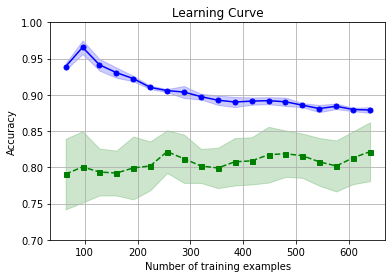

In [25]:
# Learning Curve
# "learning_curve"を使い、データ個数変えてk分割検証を自動で実施
# =============================================================

from sklearn.model_selection import learning_curve
train_sizes, train_scores, valid_scores = learning_curve(estimator=pl_1, X=X_train, y=y_train,
                                                       train_sizes=np.linspace(0.1, 1, 19), cv=10, n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, color='blue', alpha=0.2)
plt.plot(train_sizes, valid_mean, color='green', marker='s', markersize=5, linestyle='--', label='Validation accuracy')
plt.fill_between(train_sizes, valid_mean+valid_std, valid_mean-valid_std, color='green', alpha=0.2)
plt.grid()
plt.title('Learning Curve')
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.0)

plt.savefig('../image/nb006_learningcurve.png')

Text(0, 0.5, 'Accuracy')

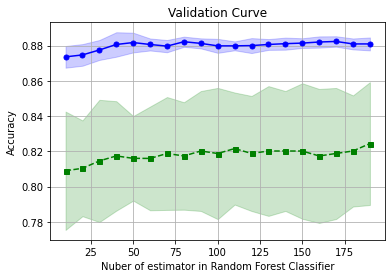

In [26]:
# Validation Curve
# "validation_curve"を使い、ランダムフォレストのn_estimatorを変えてk分割交差検証を自動で実施
# ===========================================================================================

from sklearn.model_selection import validation_curve
param_range = np.arange(10, 200, 10)
train_scores, valid_scores = validation_curve(estimator=pl_1, X=X_train, y=y_train,
                                              param_name='randomforestclassifier__n_estimators', param_range=param_range, cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, color='blue', alpha=0.2)
plt.plot(param_range, valid_mean, color='green', marker='s', markersize=5, linestyle='--', label='Validation accuracy')
plt.fill_between(param_range, valid_mean+valid_std, valid_mean-valid_std, color='green', alpha=0.2)
plt.grid()
plt.title('Validation Curve')
plt.xlabel('Nuber of estimator in Random Forest Classifier')
plt.ylabel('Accuracy')